# **Stable Diffusion** 🎨
*...using `🧨diffusers`*

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.



Let's get started!

Let’s make sure we’re connected to a GPU to run this notebook. To get a GPU, click `Runtime` -> `Change runtime type`, then change `Hardware accelerator` from `None` to `GPU`. We can verify that we’ve been assigned a GPU and view its specifications through the `nvidia-smi` command:

In [19]:
!nvidia-smi

Mon Dec  2 16:48:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0              26W /  70W |   3991MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Next, you should install `diffusers` as well `scipy`, `ftfy` and `transformers`. `accelerate` is used to achieve much faster loading.

In [20]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

  Using cached diffusers-0.11.1-py3-none-any.whl.metadata (29 kB)
Using cached diffusers-0.11.1-py3-none-any.whl (524 kB)
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.31.0
    Uninstalling diffusers-0.31.0:
      Successfully uninstalled diffusers-0.31.0


In [1]:
pip install --upgrade diffusers huggingface_hub


  Using cached diffusers-0.31.0-py3-none-any.whl.metadata (18 kB)
Using cached diffusers-0.31.0-py3-none-any.whl (2.9 MB)
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.11.1
    Uninstalling diffusers-0.11.1:
      Successfully uninstalled diffusers-0.11.1


### Stable Diffusion Pipeline

`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, we load the pre-trained weights of all components of the model. In this notebook we use Stable Diffusion version 1.4 ([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)), but there are other variants that you may want to try:
* [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1). This version can produce images with a resolution of 768x768, while the others work at 512x512.

In addition to the model id [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), we're also passing a specific `revision` and `torch_dtype` to the `from_pretrained` method.

We want to ensure that every free Google Colab can run Stable Diffusion, hence we're loading the weights from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) and also tell `diffusers` to expect the weights in float16 precision by passing `torch_dtype=torch.float16`.

If you want to ensure the highest possible precision, please make sure to remove `torch_dtype=torch.float16` at the cost of a higher memory usage.

In [2]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Next, let's move the pipeline to GPU to have faster inference.

In [3]:
pipe = pipe.to("cuda")

And we are ready to generate images and save it :

  0%|          | 0/50 [00:00<?, ?it/s]

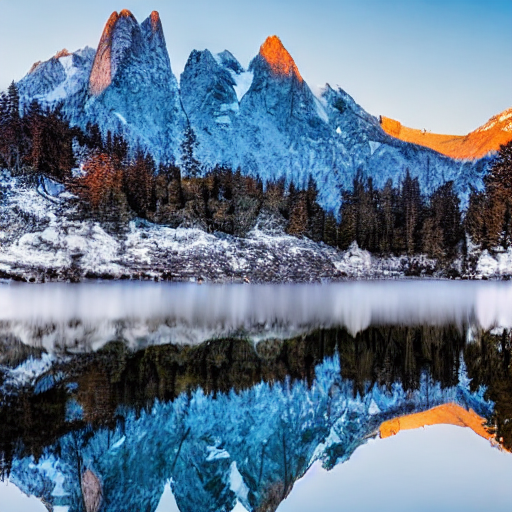

In [4]:
prompt = "A serene lake surrounded by snow-capped mountains at sunrise."
image = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can either save it such as:
image.save(f"lake_image.png")

# or if you're in a google colab you can directly display it with
image

## The styles of AudioLDM 🎺

AudioLDM was proposed in the paper [AudioLDM: Text-to-Audio Generation with Latent Diffusion Models](https://audioldm.github.io) by Haohe Liu et al. Inspired by Stable Diffusion, AudioLDM is a text-to-audio latent diffusion model (LDM) that learns continuous audio representations from CLAP latents. AudioLDM takes a text prompt as input and predicts the corresponding audio. It can generate text-conditional sound effects, human speech and music.



Next, we can install the required Python packages, namely 🧨 Diffusers and 🤗 Transformers for running the AudioLDM and CLAP models respectively:

In [5]:
!pip install --quiet --upgrade diffusers transformers

The AudioLDM model is comprised of four stages:
1. CLAP text encoder that maps a text input to a text embedding (CLAP is trained such that this text embedding is shared with the corresponding audio sample)
2. Latent diffusion model (LDM) that performs the de-noising routine to recover the audio latent
3. VAE decoder to map from the LDM latents to a log-mel spectrogram representation
4. Vocoder model to generate the audio waveform from the generated spectrogram

These four stages are depicted diagramatically below, taken from Figure 1 of the [AudioLDM paper](https://arxiv.org/abs/2301.12503):

<p align="center">
  <img src="https://github.com/sanchit-gandhi/notebooks/blob/main/audioldm.jpg?raw=true" width="600"/>
</p>

The [`AudioLDMPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/audioldm) is an end-to-end inference pipeline that wraps these four stages into a single class, enabling you to generate audio samples from text in just a few lines of code.

There are four available AudioLDM checkpoints that vary in model size and the training scheme (i.e. number of steps and audio conditioning), summarised in the table below:

| Checkpoint                                                            | Training Steps | Audio conditioning | CLAP audio dim | UNet dim | Params |
|-----------------------------------------------------------------------|----------------|--------------------|----------------|----------|--------|
| [audioldm-s-full](https://huggingface.co/cvssp/audioldm)              | 1.5M           | No                 | 768            | 128      | 421M   |
| [audioldm-s-full-v2](https://huggingface.co/cvssp/audioldm-s-full-v2) | > 1.5M         | No                 | 768            | 128      | 421M   |
| [audioldm-m-full](https://huggingface.co/cvssp/audioldm-m-full)       | 1.5M           | Yes                | 1024           | 192      | 652M   |
| [audioldm-l-full](https://huggingface.co/cvssp/audioldm-l-full)       | 1.5M           | No                 | 768            | 256      | 975M   |

We'll initialise the pipeline with the pre-trained weights from v2 version of the smallest checkpoint ([audioldm-s-full-v2](https://huggingface.co/cvssp/audioldm-s-full-v2)). We'll also load the weights in half precision (float16) to speed-up inference time:

In [6]:
from diffusers import AudioLDMPipeline
import torch

model_id = "cvssp/audioldm-s-v2"
pipe = AudioLDMPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
pipe.to("cuda");

 We'll define a [Generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) and set a [seed](https://huggingface.co/docs/diffusers/using-diffusers/reproducibility) for reproducibility. This will allow us to tweak our prompts and observe the effect that they have on the generations by fixing the starting latents in the LDM model:

In [8]:
generator = torch.Generator("cuda").manual_seed(0)

🎶 Generating Serene Lake Audio 🎧
In this section, we're going to generate a calming audio clip of a serene lake surrounded by snow-capped mountains at sunrise. 🌄💧 Using the power of deep learning, we'll create the audio from a text prompt, and then save and play the generated sound for a truly immersive experience. 🎵✨

By using a custom prompt that describes the peaceful scene and a negative prompt to avoid low-quality sounds, we'll generate high-quality audio and save it in a WAV format. Once it's done, you'll be able to listen to the soothing sounds right here! 🔊🎶

Let’s dive into it and enjoy the serene sound of nature! 🌅

In [9]:
from IPython.display import Audio
import torch
import soundfile as sf  # To save audio in WAV format

# Define the prompt and negative prompt
prompt = "A serene lake surrounded by snow-capped mountains at sunrise."
negative_prompt = "Low quality, average quality"

# Set up the generator and inference parameters
generator = torch.Generator("cuda").manual_seed(0)

# Generate the audio
audio = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=10, audio_length_in_s=5, generator=generator).audios[0]

# Save the generated audio to a WAV file
sf.write("lake_audio.wav", audio, 16000)  # Save at 16000 Hz

# Play the audio in the notebook
Audio("lake_audio.wav", rate=16000, autoplay=True)


  0%|          | 0/10 [00:00<?, ?it/s]

### 🌟 **Exploring Multimodal Comparisons with ImageBind** 🌍

Now, let’s take our creative process a step further! 🚀

In this section, we’ll dive into the fascinating world of **multimodal learning** where **text**, **image**, and **audio** come together to create meaningful comparisons. 🖼️🎶📝

### **What Are We Doing Here?** 🤔

We’ll be using **ImageBind** to generate **embeddings** for the following:

- **Text**: A description of a scene or object 📝
- **Image**: A visual representation of the scene 🖼️
- **Audio**: A sound corresponding to the scene 🔊

Once the embeddings are generated, we’ll **compare** how similar the **text** is to both the **image** and the **audio**. 🔄 This will help us understand how the model aligns these different modalities based on the same text prompt.

### **Why Is This Exciting?** 🎉

By measuring the **similarity** between these embeddings, we can see how well the model **associates** the description with both an image and an audio clip. This opens the door to exciting possibilities for **cross-modal** AI, where a single prompt can generate and link multiple types of media together. 🌄🔊

Let’s explore the exciting world of **multimodal AI** and see how these different forms of data interact! 🤖✨


In [18]:
# Clone the ImageBind repository
!git clone https://github.com/facebookresearch/ImageBind.git
%cd ImageBind

# Install ImageBind without optional dependencies
!pip install . --no-deps


Cloning into 'ImageBind'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 146 (delta 60), reused 39 (delta 39), pack-reused 58 (from 1)
Receiving objects: 100% (146/146), 2.64 MiB | 1.72 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/ImageBind
Processing /content/ImageBind
  Preparing metadata (setup.py) ... done
  Created wheel for imagebind: filename=imagebind-0.1.0-py3-none-any.whl size=1385509 sha256=50636302a49582361710ccb98574993867245963fff7d04ed06d60d353bc3149
  Stored in directory: /tmp/pip-ephem-wheel-cache-wnn6w9mk/wheels/ad/5e/c2/2d4522d460c7edb4d25e485156196bf31b78d822ccec81bffd
Successfully built imagebind
  Attempting uninstall: imagebind
    Found existing installation: imagebind 0.0.1.dev0
    Uninstalling imagebind-0.0.1.dev0:
      Successfully uninstalled imagebind-0.0.1.dev0


In [ ]:
!pip install soundfile numpy fvcore iopath pytorchvideo


In [ ]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 --index-url https://download.pytorch.org/whl/cu117


In [ ]:
# Install missing dependencies
!pip install cartopy eva-decord==0.6.1 ftfy types-regex mayavi timm==0.6.7


In [1]:
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load ImageBind model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

# Example inputs
text_prompts = [
    "A serene lake surrounded by snow-capped mountains at sunrise."
]

# Make sure these files exist in your Colab environment
image_paths = ["lake_image.png"]  # Replace with your actual image file path
audio_paths = ["lake_audio.wav"]  # Replace with your actual audio file path

# Load and transform the inputs
inputs = {
    ModalityType.TEXT: data.load_and_transform_text(text_prompts, device),
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device),
}

# Generate embeddings for the inputs
with torch.no_grad():
    embeddings = model(inputs)

# Compare modalities by calculating similarity (dot product of embeddings)
text_to_image_similarity = torch.softmax(
    embeddings[ModalityType.TEXT] @ embeddings[ModalityType.VISION].T, dim=-1
)
text_to_audio_similarity = torch.softmax(
    embeddings[ModalityType.TEXT] @ embeddings[ModalityType.AUDIO].T, dim=-1
)
image_to_audio_similarity = torch.softmax(
    embeddings[ModalityType.VISION] @ embeddings[ModalityType.AUDIO].T, dim=-1
)

# Print the similarity results
print("Text-to-Image Similarity:", text_to_image_similarity)
print("Text-to-Audio Similarity:", text_to_audio_similarity)
print("Image-to-Audio Similarity:", image_to_audio_similarity)

# Optionally, print out the embeddings for analysis
print("\nText Embedding:", embeddings[ModalityType.TEXT])
print("\nImage Embedding:", embeddings[ModalityType.VISION])
print("\nAudio Embedding:", embeddings[ModalityType.AUDIO])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Text-to-Image Similarity: tensor([[1.]], device='cuda:0')
Text-to-Audio Similarity: tensor([[1.]], device='cuda:0')
Image-to-Audio Similarity: tensor([[1.]], device='cuda:0')

Text Embedding: tensor([[ 1.6696,  2.8879, -1.5692,  ..., -1.1053, -2.3144,  1.8942]],
       device='cuda:0')

Image Embedding: tensor([[-0.0301,  0.0004, -0.0088,  ..., -0.0467, -0.0089,  0.0102]],
       device='cuda:0')

Audio Embedding: tensor([[-6.2029e-05,  6.5309e-01,  3.1490e-01,  ..., -1.6283e-01,
         -2.7920e-01,  1.0958e-01]], device='cuda:0')


**indicates that the similarity values between the modalities (Text, Image, and Audio) are all 1, which means that the model perceives the provided text, image, and audio as perfectly similar to each other based on the embeddings it generated.**